## IMR hierarchical analysis

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import seaborn as sns
import utils
from matplotlib.lines import Line2D

sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
plt.rcParams.update(utils.rcParams)

numpy.random.seed(1234)

# ignore seaborn warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
input_path = 'cache/{run}/{param}_{hyper}.txt.gz'

runs = ['GWTC3','GWTC3_wo_190814','GWTC2','GWTC1']  #'GWTC3_wo_190503','GWTC3_wo_190503_190814'
params = {
    'dchifbychif': r'$\Delta \chi_\mathrm{f}/ \bar{\chi}_\mathrm{f}$',
    'dMfbyMf': r'$\Delta M_\mathrm{f}/ \bar{M}_\mathrm{f}$',
} 

draws = {r: {p: np.loadtxt(input_path.format(run=r, param=p, hyper='pop')) for p in params} for r in runs}

In [4]:
ci_dict = {}

for r, d in draws.items():
    ci_dict[r] = {}
    for p, samples in d.items():
        mean = np.median(samples)
        left = np.percentile(samples, 5)
        right = np.percentile(samples, 95)
        ci_dict[r][p] = (mean, left, right)

## Plots

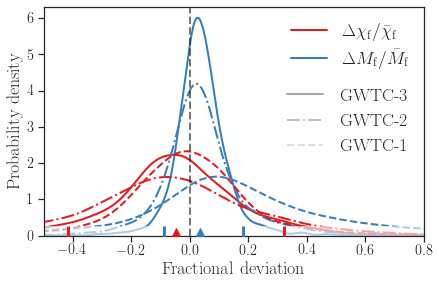

In [5]:
xlim = [-0.5, 0.8]

sns.set_palette('Set1')

kws = {
    'GWTC3': {
        'ls': '-',
        'alpha': 0.7,
        'lw': 2,
        'label': 'GWTC-3',
    },
    'GWTC2': {
        'ls': '-.',
        'alpha': 0.5,
        'lw': 2,
        'label': 'GWTC-2',
    },
    'GWTC1': {
        'ls': '--',
        'alpha': 0.25,
        'lw': 2,
        'label': 'GWTC-1',
    },
}

ul_run = runs[0]
lines = {v.pop('label'): Line2D([0], [0], c='gray', **v)
         for v in kws.values()}

for run in kws.keys():
    for i, (param, label) in enumerate(params.items()):
        c = sns.color_palette()[i]
        l = label if run==runs[0] else None
        sns.distplot(draws[run][param], label=l, hist=False,
                     kde_kws={'gridsize': 500, **kws[run]},
                     hist_kws={'range': xlim}, color=c)
        # add credible interval
        if run == ul_run:
            lkws = {'ls': 'none', 'c': c, 'zorder': 3}
            cis = ci_dict[run][param]
            plot(cis[1:], [0, 0], marker='|', ms=20, mew=3, mfc='none', **lkws)
            plot(cis[0:1], [0.1], marker='^', ms=8, **lkws)

# add transparent stripe
x = linspace(xlim[0], xlim[-1], 100)
plot(x, [0.1]*len(x), lw=12, c='w', alpha=0.6)
plt.gca().axvline(0, c='k', ls='--', lw=2, alpha=0.6)

# format axes
plt.xlim(*xlim)
plt.ylim(0, plt.gca().get_ylim()[1])
plt.xlabel(r'Fractional deviation')
plt.ylabel('Probability density')

# add custom legend
l1 = plt.legend(framealpha=0.7, edgecolor='w')
plt.legend(lines.values(), lines.keys(), loc='center right',
           edgecolor='w', handletextpad=0.95)
plt.gca().add_artist(l1)

plt.savefig('./fig/imrct_hier.pdf', bbox_inches='tight')

## Hyperparameters

In [6]:
input_path = 'cache/{run}/{param}_{hyper}.txt.gz'
hparams = ['mu', 'sigma', 'pop']
hyper_dict = {r: {p: {h: np.loadtxt(input_path.format(run=r, param=p, hyper=h)) for h in hparams} for p in params} for r in runs}

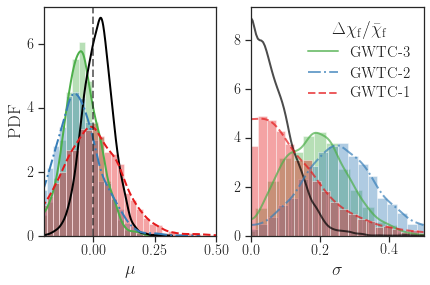

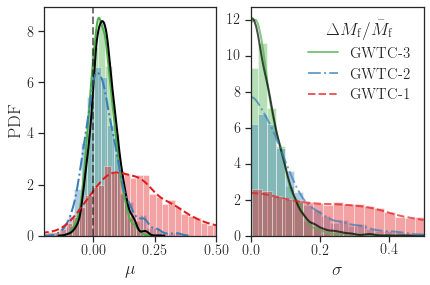

In [7]:
kws = {
    'GWTC3': {
        'ls': '-',
        'alpha': 0.7,
        'lw': 2,
        'color': sns.color_palette()[2],
        'label': 'GWTC-3',
    },
#     'GWTC3_wo_190503': {
#         'ls': '-',
#         'alpha': 0.7,
#         'lw': 2,
#         'color': 'orange',
#         'label': '',
#     },
    'GWTC3_wo_190814': {
        'ls': '-',
        'alpha': 0.7,
        'lw': 2,
        'color': 'black',
        'label': '',
    },
#     'GWTC3_wo_190503_190814': {
#         'ls': '-',
#         'alpha': 0.7,
#         'lw': 2,
#         'color': 'black',
#         'label': '',
#     },
    'GWTC2': {
        'ls': '-.',
        'alpha': 0.7,
        'lw': 2,
        'color': sns.color_palette()[1],
        'label': 'GWTC-2',
    },
    'GWTC1': {
        'ls': '--',
        'alpha': 0.7,
        'lw': 2,
        'color': sns.color_palette()[0],
        'label': 'GWTC-1',
    },
}

for param in params.keys():
    fig, axs = plt.subplots(1, 2)
    for run, kw in kws.items():
        # mu
        if (run=='GWTC3_wo_190814'):  #run=='GWTC3_wo_190503' or run=='GWTC3_wo_190503_190814'
            hist = False
        else:
            hist = True
        sns.distplot(hyper_dict[run][param]['mu'], label=l, hist=hist,
                     kde_kws={'gridsize': 500, **kw},
                     hist_kws={'range': xlim, 'color': kw['color']},
                     ax=axs[0])

        # sigma
        samples = hyper_dict[run][param]['sigma']
        sns.distplot(samples, label=l, hist=hist, kde=False,
                     norm_hist= True, ax=axs[1],
                     hist_kws={'range': xlim, 'color': kw['color']})
        pdf = utils.Bounded_1d_kde(samples, xlow=0)
        x = np.linspace(0, 0.5, 100)
        axs[1].plot(x, pdf(x), **kws[run])

    axs[0].axvline(0, c='k', ls='--', lw=2, alpha=0.6)

    # add custom legend
    axs[1].legend(framealpha=0.7, edgecolor='w', fontsize=15, title=params[param])
    # axs[0].legend_.remove()

    # format axes
    axs[0].set_xlim(-0.2, 0.5)
    axs[0].set_ylim(0, axs[0].get_ylim()[1]);
    axs[1].set_xlim(0, 0.5);

    axs[0].set_xlabel(r'$\mu$');
    axs[1].set_xlabel(r'$\sigma$');
    axs[0].set_ylabel('PDF');

    fig.savefig('./fig/imrct_hier_hyper_%s.pdf'%param, bbox_inches='tight')

## Macros

In [8]:
par_keys = {'dMfbyMf': 'Mf', 'dchifbychif': 'Chif'}
run_keys = {'GWTC3': 'GWTC3', 'GWTC2': 'GWTC2', 'GWTC1': 'GWTC1'}
hyper_dict = {r: {p: {h: np.loadtxt(input_path.format(run=r, param=p, hyper=h)) for h in hparams} for p in params} for r in run_keys.keys()}
ci_dict_mu = {r: {} for r in run_keys.keys()}

macros = []
for hp in hparams:
    for p, pk in par_keys.items():
        case_list = []
        for r, rd in hyper_dict.items():
            rk = run_keys[r]
            samples = hyper_dict[r][p][hp]
#             if hp == 'sigma':
#                 # compute 90% UL
#                 ul = np.percentile(samples, 90)
#                 s = r'{%s}{\ensuremath{%.2f}}' % (rk, ul)
#             else:
                # compute 90% interval
            med = np.percentile(samples, 50)
            lo = med - np.percentile(samples, 5)
            hi = np.percentile(samples, 95) - med
            s = r'{%s}{\ensuremath{%.2f^{+%.2f}_{-%.2f}}}' % (rk, med, hi, lo)
            if hp == 'mu': ci_dict_mu[r][p] = (med, med+left, right+med)
            case_list.append(s)
        cases = ''.join(case_list)
        macros.append(r'\newcommand{\Imr%sHier%s}[1]{\IfEqCase{#1}{%s}}' % (pk, hp.capitalize(), cases))
        
with open('./macros/imrct_macros_hier.tex', 'w') as f:
    f.write('\n'.join(macros))